<a href="https://colab.research.google.com/github/DevMLV/alzheimer_neural_netwoork/blob/main/alzheimer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Utilizzo del DeepLearning per estrarre un modello che ci consente di prevenire l'Alzheimer**.

Per il progetto è stato richiesto l'accesso al dataBase ADNI (**Alzheimer's Disease Neuroimaging initiative**). 
In quanto tali, gli investigatori all'interno dell'ADNI hanno contribuito alla progettazione e all'implementazione dell'ADNI e/o hanno fornito dati ma non hanno partecipato all'analisi o alla stesura di questo rapporto. Un elenco completo degli investigatori ADNI è disponibile all'indirizzo: https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Acknowledgement_List.pdf.

Il progetto si suddivide in tre ambiti:

1.   Fase di preprocessing;
2.   Fase di costruzione del database **TFRecord**;
3.   Creazione del modello utilizando le reti neurali (**ResNet3D** e **VGG-16**)



# Setup enviroment

In questa sezione prevediamo il setup dell'enviroment.

Iniziamo con l'instazione della libreria SimpleITK.

In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Proseguiamo con l'importazione delle librerie necessarie.

In [ ]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#from dltk.io import preprocessing
from skimage import filters
import os
#from nipype.interfaces import fsl
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn import metrics as skmetrics
from scipy import interp
from itertools import cycle
import os
import json
from keras.layers import Conv3D, MaxPooling3D, Input,Flatten,Dense,Dropout, Conv2D, MaxPool2D
from keras.models import Model
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from importlib.machinery import SourceFileLoader
keras_resnet3d = '/content/drive/MyDrive/ColabNotebooks/progetto/keras-resnet3d/'
resnet3d = SourceFileLoader('resnet3d', os.path.join(keras_resnet3d, 'resnet3d/resnet3d.py')).load_module()
from resnet3d import Resnet3DBuilder

# **Fase di PreProcessing**

In questa sezione è prevista una fase molto importante del progetto, ovvero il processing delle immagini.
Il nostro set di immagini è costituito da **2042** immagini **MRI** di estensione .nii cosi suddivise:

1.   MCI (***mild cognitive impairment***): 1206 immagini;
2.   AD (***Alzheimer's disease***): 269 immagini;
3.   CN (***cognitively normal***): 567 immagini;

In questa fase prevederemo i seguenti step:


1.   Normalizzazioni delle immagini;
2.   Registrazione delle immagini (fase molto importante realizzata con la  
     libreria SimpleITK);
3.   Fase di rimozione del craino (**Skull-stripping**)

## Descrizioni funzioni create per il preprocessing

La prima parte include l'importazione delle librerie necessarie per la realizzazione del processing delle immagini.

Tra queste librerie è importante segnalare la "SimpleITK" utile per la fase di registrazione delle immagini.
Nelle prossime sezioni spiegheremo perchè è cosi importante questa fase, ma adesso è necessario evidenziare che l'installazione della libreria **SimpleITK** crea non pochi grattacapi.
L'installazione è abbastanza lunga (impiega circa 4 ore) e per tale installazione è stata seguita la guida presente al link:

https://gist.github.com/vfmatzkin/0fcc79a61f9bafcc2113fd83a8900937

L'installazione della libreria e tutta la fase di pre-processing è stata realizzata su **Ubuntu 20.4**.

***Attenzione: Per l'installazione ho seguito diverse guide ma tutte con esito assolutamente negativo. L'unica che mi ha dato in effetti la possibilità di utilizzarla è la guida riportata nel link sopra***.

In [ ]:
def ricampiona_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' Questa funzione ricampiona le immagini in voxel isotropici da 2 mm.
      
        Parametri:
            itk_image -- Immagine in simpleITK format
            out_spacing -- Rappresentazione spaziale di ogni voxel
            
        Output: 
            Restituisce immagine in simpleITK format
    '''
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

La funzione **ricampiona_img** ci consente di ricampionare a una risoluzione ***isotropica di 2 mm³***, il che significa che ogni voxel rappresenterebbe 2 mm³ di spazio nel mondo "reale".

In [ ]:
def registra_img(sitk_fixed, sitk_moving,bspline=False):
    ''' Registrazione delle immagini utilizzando SimpleElastix
        Utilizzo "affine transformation".
        
        Parametri:
            Immagine di fix (di riferimento - sitk_fixed) -- Immagine atlas (sitk .nii)
            dimmagine di movimento (sitk_moving) -- Immagine da registrare
                           (sitk .nii)
    '''
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk_fixed)
    elastixImageFilter.SetMovingImage(sitk_moving)

    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    if bspline:
        parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    elastixImageFilter.Execute()
    return elastixImageFilter.GetResultImage()

La funzione **registra_img**  ci consente di effettuare la fase di registrazione delle immagini.
La fase di registrazione consiste in effetti ad adattare l'immagine letta (detta moving), ad un immagine di riferimento (chiamata solitamente atlante).
L'adattamento ci permette di individuare le regioni in comune ad entrambe le immagini che rappresentano le stesse strutture anatomiche.
Per una CNN individuare una determinata regione dell'immagine come rilevante è più semplice se sono adattate ad una di riferimento.
In più, le immagini che riceviamo dal database di riferimento (ADNI) hanno formato e posizioni diverse, queste fase ci consente di adattarle tutte alla stessa maniera.

In [ ]:
def rimozione_cranio_nii(original_img, destination_img, frac=0.3):
    ''' Funzione che elimina la parte del cranio dell'immagine data e restituisce come output una nuova immagine
        Uses FSL-BET 
        (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide#Main_bet2_options:)
        
        Parameters:
            original_img -- Original nii image
            destination_img -- The new skull-stripped image
            frac -- Fractional intensity threshold for BET
    '''
    
    btr = fsl.BET()
    btr.inputs.in_file = original_img
    btr.inputs.frac = frac
    btr.inputs.out_file = destination_img
    btr.cmdline
    res = btr.run()

La funzione **rimozione_cranio_nii** ci consente di rimuovere la parte del craino dell'immagini .nii data in input.
L'obiettivo è ottenere un'immagine finale il più pulita possibile, contenente solo le informazioni rilevanti per il compito da svolgere. Ovviamente, nel caso dell'AD, nessuno dei biomarcatori più rilevanti si trova nel cranio. 

In [ ]:
def register_and_save(filename, path, atlas):
    ''' Funzione che processa il set di immagini fornito in input
        
        Parameters:
            filename -- Nome del file .nii 
            path -- Percorso dove le immagini sono collocate
            atlas -- Immagine di riferimento
    '''
    
    # separte the name of the file by '_'
    splitted_name = filename.strip().split('_')
    # sometimes residual MacOS files appear; ignore them
    if splitted_name[0] == '.': return
    
    dim=len(splitted_name)-1
    splitted_name_app = splitted_name[dim]
    splitted_name_app = splitted_name_app.strip().split('.')
    # save the image ID
    image_ID = splitted_name_app[0]
    
    # sometimes empty files appear, just ignore them
    if image_ID == '': return
    # transform the ID into a int64 numpy variable for indexing
        
    # with the ID, index the information we need
    row_index = description.index[description['Image Data ID'] == image_ID].tolist()[0]
    # obtain the corresponding row in the dataframe
    row = description.iloc[row_index]
    # get the label
    label = row['Group']
    
    # prepare the origin path
    complete_file_path = os.path.join(path, filename)
    # load sitk image
    sitk_moving = sitk.ReadImage(complete_file_path)
    sitk_moving = ricampiona_img(sitk_moving)
    
    registrated = registra_img(atlas, sitk_moving)
    
    # prepare the destination path
    complete_new_path = os.path.join(REG_DB, 
                                     label,
                                     filename)
    sitk.WriteImage(registrated, complete_new_path)
    complete_new_skull = complete_new_path+"-skull"
    rimozione_cranio_nii(complete_new_path, complete_new_skull, frac=0.2)
    os.remove(complete_file_path)

La funzione **register_and_save** rappresenta in effetti il corpo del processing delle immagini.
Richiama tutte le funzioni spiegate in precedenza:


1.   ***ricampiona_img***: Ricampionamento immagini;
2.   ***registra_img***: Registrazione delle immagini;
3.   ***rimozione_cranio_nii***: Rimozione del craino dalla immagini fornite. 




## Esempio di utilizzo delle librerie di pre-processing

Utilizzo della libreria SimpleITK per visualizzare un immagine di esempio MRI fornita da ADNI.

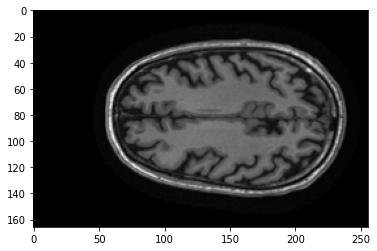

In [ ]:
file_nii="/media/sf_D_DRIVE/TESI/ADNI/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii"
sitk_image = sitk.ReadImage(file_nii)
# trasforma immagine in un numpy array
img = sitk.GetArrayFromImage(sitk_image)
# visualizza immagine
plt.imshow(img[:, :, 70], cmap='gray')
plt.show()

Utilizzo della libreria matplotlib.pyplot per la visualizzazione dell'immagine .nii caricata con la libreria SimpleITK.
Ci sono tre dimensioni che possono essere utilizzate per il slicing. Nell'esempio è stata utilizzata la sezione 70 della terza dimensione.

Visualizziamo adesso l'immagine utilizzata come riferimento (ATLAS MNI 305) (scaricata dal sito https://www.mcgill.ca/bic/software/tools-data-analysis/anatomical-mri/atlases/mni-305)

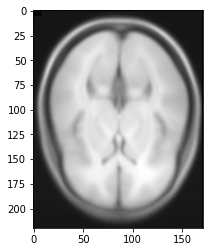

In [ ]:
atlas = sitk.ReadImage('/media/sf_D_DRIVE/TESI/ATLAS/atlas.nii')
# trasforma immagine in un numpy array
imgatlas = sitk.GetArrayFromImage(atlas)
# visualizza immagine
plt.imshow(imgatlas[70, :, :], cmap='gray')
plt.show()

Adesso come esempio vedremo sia la fase di ricampionamento che registrazione dell'immagine.
Sarà interessante vedere come l'immagine di movimento (quella in analisi) si adegua all'atlas.

In [ ]:
atlas = sitk.ReadImage('/media/sf_D_DRIVE/TESI/ATLAS/atlas.nii')
atlas = ricampiona_img(atlas)
REG_DB = '/media/sf_D_DRIVE/TESI/REGISTERED_TEST'
file="ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii"
path="/media/sf_D_DRIVE/TESI/ADNI"
description = pd.read_csv('/media/sf_D_DRIVE/TESI/ATLAS/ADNI1_Complete_2Yr_1.5T_10_22_2022.csv')
register_and_save(file,path,atlas)

Rivediamo immagine originale:

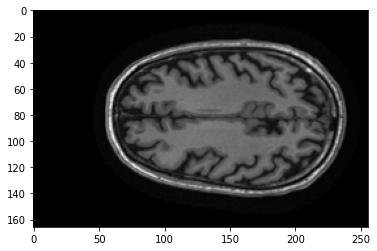

(166, 256, 256)

In [ ]:
file_nii="/media/sf_D_DRIVE/TESI/ADNI/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii"
sitk_image = sitk.ReadImage(file_nii)
# trasforma immagine in un numpy array
img = sitk.GetArrayFromImage(sitk_image)
# visualizza immagine
plt.imshow(img[:, :, 70], cmap='gray')
plt.show()
img.shape

La stessa immagine viene ricampionata:

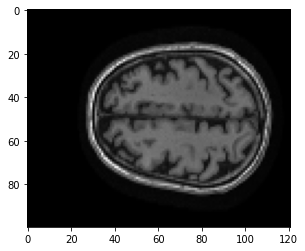

(100, 121, 121)

In [ ]:
file_nii="/media/sf_D_DRIVE/TESI/ADNI/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii"
sitk_image = sitk.ReadImage(file_nii)
file_campionata=ricampiona_img(sitk_image)
# trasforma immagine in un numpy array
img_camp = sitk.GetArrayFromImage(file_campionata)
# visualizza immagine
plt.imshow(img_camp[:, :, 30], cmap='gray')
plt.show()
img_camp.shape

Visualizziamo l'atlas di riferimento MNI 305 

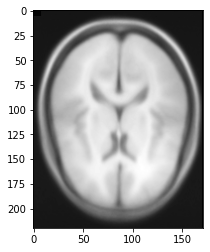

(156, 220, 172)

In [ ]:
atlas = sitk.ReadImage('/media/sf_D_DRIVE/TESI/ATLAS/atlas.nii')
# trasforma immagine in un numpy array
imgatlas = sitk.GetArrayFromImage(atlas)
# visualizza immagine
plt.imshow(imgatlas[80, :, :], cmap='gray')
plt.show()
imgatlas.shape

Di seguito l'immagine registrata:

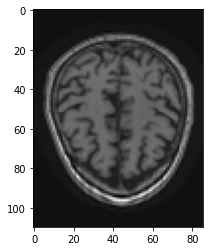

(78, 110, 86)

In [ ]:
FILE_REG="/media/sf_D_DRIVE/TESI/REGISTERED_TEST/CN/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii"
FILE_REGISTRATO = sitk.ReadImage(FILE_REG)
# trasforma immagine in un numpy array
imgreg = sitk.GetArrayFromImage(FILE_REGISTRATO)
# visualizza immagine
plt.imshow(imgreg[60, :, :], cmap='gray')
plt.show()
imgreg.shape

Infine, vediamo immagine con eliminazione del craino.

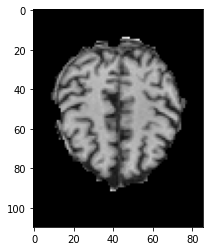

(78, 110, 86)

In [ ]:
FILE_REG="/media/sf_D_DRIVE/TESI/REGISTERED_TEST/CN/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii-skull.nii.gz"
FILE_REGISTRATO = sitk.ReadImage(FILE_REG)
# trasforma immagine in un numpy array
imgreg = sitk.GetArrayFromImage(FILE_REGISTRATO)
# visualizza immagine
plt.imshow(imgreg[60, :, :], cmap='gray')
plt.show()
imgreg.shape

## Esecuzione pre-processing

In questa sezione prevederemo l'esecuzione vera e propria del preprocessing delle immagini.

In [ ]:
# original database
DATABASE = '/media/sf_D_DRIVE/TESI/ADNI'
# registered and organized database
REG_DB = '/media/sf_D_DRIVE/TESI/REGISTERED'
REG_DB_SUBFOLDERS = ['AD/', 'MCI/', 'CN/']

In [ ]:
atlas = sitk.ReadImage('/media/sf_D_DRIVE/TESI/ATLAS/atlas.nii')
atlas = ricampiona_img(atlas)
description = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/dataset/ADNI1_Complete_2Yr_1.5T_10_22_2022.csv')
description.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,10/20/2022
1,I123812,941_S_1311,MCI,M,71,5,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/21/2008,NiFTI,10/20/2022
2,I97341,941_S_1311,MCI,M,70,3,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,10/20/2022
3,I143861,941_S_1311,MCI,M,71,6,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/31/2009,NiFTI,10/20/2022
4,I97327,941_S_1311,MCI,M,69,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,10/20/2022


Il file **ADNI1_Complete_2Yr_1.5T_10_22_2022.csv**  rappresenta la lista delle immagini che costituiscono il dataset utilizzato in questa ricerca.


In [ ]:
for path, dirs, files in os.walk(DATABASE):
    if files:
        for file in files:
            try:
                print("file: ", file)
                print("path: ", path)
                print("path: ", atlas)
                register_and_save(file, 
                                  path, 
                                  atlas)
            except RuntimeError:
                print('Exception with', os.path.join(path, file))

file:  ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii
path:  /media/sf_D_DRIVE/TESI/ADNI
path:  Image (0x4335840)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 15488
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 15464
  UpdateMTime: 15486
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1, 1, 1]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1, 1, 1]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1, 1, 1]
  Spacing: [2, 2, 2]
  Origin: [86.095, 126.51, -68.25]
  Direction: 
-1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
-2 0 0
0 -2 0
0 0 2

  PointToIndexMatrix: 
-0.5 0 0
0 -0.5 0
0 0 0.5

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContaine

# Costruzione del database TFRecord

## Descrizione funzioni create per la creazione del db TFRecord

Per migliorare le prestazioni nella fase di addestramento del modello abbiamo costruito un database di tipo TF.
L'utilizzo del TFRecord ci permette di memorizzare una sequenza di record binari.
E' progettato per l'uso con tensorflow e viene utilizzato in tutte le API di livello superiore come TFX.

In [ ]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))
  
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

Funzioni progettata per la gestione delle feature che possono essere:



1.   **BytesList**: gestione tipi "string" e "byte"
2.   **FloatList**: gestione tipi "float" e "double"
3.   **Int64List**: gestione tipi "bool/enum/int32/uint32/int64/uint64"




In [ ]:
def load_image_3D(abs_path):
  ''' Carica l'immagin .nii e la relativa label da percorso (path) indicato
      
      Parameters:
        abs_path -- Absolute path, filename included
        
      Returns:
        img -- The .nii image, converted into a numpy array
        label -- The label of the image
        
  '''
  # obtain the label from the path (it is the last directory name)
  split_path = abs_path.split('/')
  label = LABELS[split_path[-2]]
  # obtain the ID of the subject
  img_name = split_path[-1]
  subject = '_'.join(img_name.split('_')[1:4])
  # load the image with SimpleITK
  sitk_image = sitk.ReadImage(abs_path)
  # transform into a numpy array
  img = sitk.GetArrayFromImage(sitk_image)  
  
  return img, label, subject

La funzione **load_image_3D**,  indicato un percorso specifico  (path) ritorna immagine (di tipo sitk), label e subject.

In [ ]:
def create_tf_record(img_filenames, tf_rec_filename):
  ''' Funzione che crea il TFR file 
      Parameters:
        img_filenames -- Array with the path to every
                         image that is going to be included
                         in the TFRecords file.
        tf_rec_filename -- Name of the TFRecords file.
  '''
  
  # apro il file TFR
  writer = tf.io.TFRecordWriter(tf_rec_filename)
  
  # iterate through all .nii files
  for meta_data in img_filenames:

    # load the image and label
    img, label, subject = load_image_3D(meta_data)    
    # also save the preprocessing information and the subject age and sex
    meta_data_split = meta_data.split('/')
    filename_split = meta_data_split[-1].split('_')
    
    # save the preprocessing technique used
    preprocessing = '_'.join(filename_split[5:-3])
    
    # get the image ID    
    dim=len(filename_split)-1
    splitted_name_app = filename_split[dim]
    splitted_name_app = splitted_name_app.strip().split('.')
    # save the image ID
    image_ID = splitted_name_app[0]
    age_and_sex = description.loc[description['Image Data ID'] == image_ID, ['Age','Sex']].iloc[0]
    print(label , " - ", image_ID, " - ", subject)
    # obtain the corresponding row in the dataframe
    # create a feature
    feature = {'label': _int64_feature(label),
               'subject': _bytes_feature(subject.encode('utf-8')),
               'preprocessing': _bytes_feature(preprocessing.encode('utf-8')),
               'subject_age': _int64_feature(age_and_sex[0]),
               'subject_sex': _bytes_feature(age_and_sex[1].encode('utf-8')),
               'image_id': _bytes_feature(image_ID.encode('utf-8')),
               'image': _float_feature(img.ravel())}

    # create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # serialize to string and write on the file
    writer.write(example.SerializeToString())
    
  writer.close()

Questa funzione è in effetti quella cardine, ci permette di creare un TFR contenente l'informazione delle immagini.
La feature è costituita da diverse informazioni:


1.   **label**
2.   **subject**
3.   **preprocessing**
4.   **età**
5.   **sesso**
6.   **immagine ID**
7.   **immagine**

L'istruzione "example = tf.train.Example(features=tf.train.Features(feature=feature))" serve a serializzare il messaggio (questo ci consente di avere migliori prestazioni in termini di occupazione disco).


## Creazione file TFRecord 

In [ ]:
# Directory utilizzate per riportare le immagini registrate e senza craino (skull)
DB_REG_PATH = '/media/sf_D_DRIVE/TESI/REGISTERED'
DB_SS_PATH = '/content/drive/MyDrive/ColabNotebooks/dataset/SKULLTEST/'
# data subfolders (labels)
CLASS_SUBFOLDERS = ['MCI/', 'AD/', 'CN/']
DB_TF_3D_PATH = '/content/drive/MyDrive/ColabNotebooks/dataset/'
TFREC_3D_REG_TRAIN = 'train.3D.registered.tfrecords'
TFREC_3D_SS_TRAIN = 'train.3D.skull_stripped.tfrecords'
##
TFREC_3D_REG_TEST = 'test.3D.registered.tfrecords'
TFREC_3D_SS_TEST = 'test.3D.skull_stripped.tfrecords'
##
TFREC_3D_REG_VAL = 'validation.3D.registered.tfrecords'
TFREC_3D_SS_VAL = 'validation.3D.skull_stripped.tfrecords'
# 3D unsupervised TFRecords database
DB_TF_UL_PATH = 'media/sf_D_DRIVE/TESI/TFRecordsUL/'

In [ ]:
# Mapping della classificazione
LABELS = {'CN': 0, 'MCI': 1, 'AD': 2}
# shape dell'immagine 3D
IMG_SHAPE = (78, 110, 86)
N_CLASSES = len(LABELS)

In [ ]:
TEST_SPLIT = 0.15
VALIDATION_SPLIT = 0.15

In [ ]:
# inizializzazione struttura filenames
filenames = np.array([])

# Itero sulle immagini registrate senza craino (skull)
for subf in CLASS_SUBFOLDERS:
  # using the skull stripped data
  path = DB_SS_PATH + subf
  for name in os.listdir(path):
    complete_name = os.path.join(path, name)
    if os.path.isfile(complete_name):
      filenames = np.concatenate((filenames, complete_name), axis=None)

### Una volta che la struttura filenames ha tutte le immagini registrate.
### andiamo a creare il dataset di "training"/"test"/"validation".

for i in range(1000):
  np.random.shuffle(filenames)
  
test_margin = int(len(filenames) * TEST_SPLIT)
training_set, test_set = filenames[test_margin:], filenames[:test_margin]

validation_margin = int(len(training_set) * VALIDATION_SPLIT)
training_set, validation_set = training_set[validation_margin:], training_set[:validation_margin]

print('Training set:', training_set.shape)
print('Validation set:', validation_set.shape)
print('Test set:', test_set.shape)      

Training set: (1476,)
Validation set: (260,)
Test set: (306,)


Nel blocco precedente l'obiettivo è quello di creare i tre dataset (file TFrecord) utili per la fase di apprendimento e test del modello.

In [ ]:
train_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_TRAIN)
test_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_TEST)
val_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_VAL)
###
create_tf_record(training_set, train_tfrec)
create_tf_record(test_set, test_tfrec)
create_tf_record(validation_set, val_tfrec)

Assegnazione delle variabili:

1. **train_tfrec** (TFrecord di training);
2. **test_tfrec** (TFRecord di test);
3. **val_tfrec**  (TFRecord di validazione).

Fatta l'assegnazione procediamo alla creazione vera e propria dei 3 tfrecord.


# Costruzione del modello di apprendimento

## Descrizioni funzioni create per l'apprendimento

In [ ]:
def _decode(serialized_example):
    ''' Funzione che decodifica il dato serializzato nella fase di costruzione del file TFR
    '''
    # decode examples stored in TFRecord
    feature = tf.io.parse_single_example(
        serialized_example,
        features = {
            'image': tf.io.FixedLenFeature(IMG_SHAPE, tf.float32),
            'label': tf.io.FixedLenFeature([], tf.int64),
            'subject': tf.io.FixedLenFeature([], tf.string),
            'preprocessing': tf.io.FixedLenFeature([], tf.string),
            'subject_sex': tf.io.FixedLenFeature([], tf.string),
            'subject_age': tf.io.FixedLenFeature([], tf.int64),
            'image_id': tf.io.FixedLenFeature([], tf.string)
        }
    )
    
    return feature['image'], feature['label']

La funzione **_decode** ci consente di decodificiare il record serializzato nel file TFrecord.
La funzione ci restituisce sia l'immagine che la corrispetiva label.

In [ ]:
def dataset_parser(filepath, ciclo, mapping_fn=None, preprocessing_fn=None, n_classes=3):
  ''' Questo metodo è una pipeline per l'alimentazione
      tfrecord dati in un modello Keras.
      
      Parameters:
        filepath -- The complete path to the TFRecord file
        batch_size -- The size of the batch
        mapping_fn -- Function for extra mapping the values. 
                      For adapting the records to binary classification.
        preprocessing_fn -- Function for image preprocessing
        n_classes -- Number of possible classes for the current implementation
        
      Returns:
        image -- Tensor with the image
        label -- Tensor with the label
  '''
  
  # create and configure the dataset
  dataset = tf.data.TFRecordDataset(filepath).map(_decode)
  if mapping_fn != None: dataset = dataset.map(mapping_fn)
  if preprocessing_fn != None: dataset = dataset.map(preprocessing_fn)
    
  dataset = dataset.shuffle(SHUFFLE_BUFFER).repeat()
  dataset = dataset.batch(ciclo)
  dataset = dataset.prefetch(1)
  
  # get example
  iterator = iter(dataset)
  image, label = next(iterator)
  
  # encode the label
  label = tf.one_hot(label, n_classes)
  
  return image, label

In [ ]:
def plot_training(history, title):
  ''' Plot the training and validation loss + accuracy
  '''
  
  acc = history.history['acc'][1:]
  val_acc = history.history['val_acc'][1:]
  loss = history.history['loss'][1:]
  val_loss = history.history['val_loss'][1:]
  epochs = range(len(acc))
  
  plt.figure(figsize=(20, 8))

  plt.subplot(121)
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.legend(('Training accuracy', 'Validation accuracy'),
             loc='upper right')
  plt.title(title + '- Accuracy')

  plt.subplot(122)
  plt.plot(epochs, loss, 'b.')
  plt.plot(epochs, val_loss, 'b')
  plt.legend(('Training loss', 'Validation loss'),
             loc='upper right')
  plt.title(title)
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

In [ ]:
def get_data_for_predict(tfrec_file,ciclo,decoding_fn, mapping_fn=None, preprocessing_fn=None):
  ''' Legge e restituisce i dati da un file TFRecord.
      Questa funzione è utilizzata solo per lavorare con i dati di test.
      
      Params:
        tfrec_file -- Absolute path to the .tfrecord
        decoding_fn - Function used to decode the serialized examples
        mapping_fn -- Optional extra mapping for binary classification
        preprocessing_fn -- Function for image preprocessing
      
      Returns:
        images and labels (tuple)
  '''
  # creazione delle strutture di images e label
  images = np.empty((n_test_samples, IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2], IMG_SHAPE[3]))
  labels = np.empty((n_test_samples))
  # Estrazione dal file TFRecord e creatore dell'iterator
  dataset = tf.data.TFRecordDataset(tfrec_file).map(decoding_fn)
  dataset = dataset.shuffle(SHUFFLE_BUFFER).repeat()
  dataset = dataset.batch(ciclo,drop_remainder=True)
  dataset = dataset.prefetch(1)
  if preprocessing_fn != None: 
     dataset = dataset.map(preprocessing_fn)
  #
  iterator = iter(dataset)
  images, labels = next(iterator)
  return images, labels

La funzione **get_data_for_predict** ci consente di parserizzare il dataset estratto dal tfRecord. In particolare il dataset che contiene l'informazione relative alla fase di test.

In [ ]:
def compute_auc(model, images, labels, target_names, title):
  ''' Computes the ROC and AUC for a given model
      and a specific test set.
      
      Parameters:
        model -- The trained model
        images -- Images of the test set
        labels -- Labels for the images
        target_names -- Names for the labels
  '''
  n_classes = len(target_names)
  y_true = tf.keras.utils.to_categorical(labels, n_classes)
  y_pred = model.predict(x=images)
  
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = skmetrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = skmetrics.auc(fpr[i], tpr[i])
  
  # compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = skmetrics.roc_curve(y_true.ravel(), y_pred.ravel())
  roc_auc['micro'] = skmetrics.auc(fpr['micro'], tpr['micro'])
  
  # compute macro-average ROC curve and ROC area
  # first aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = skmetrics.auc(fpr['macro'], tpr['macro'])

  # plot all ROC curves
  plt.figure(figsize=(10, 10))
  plt.plot(fpr['micro'], tpr['micro'],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['micro']),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr['macro'], tpr['macro'],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(target_names[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

In [ ]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
  ''' Define an early stopping callback to stop training
      when a certain validation loss value is achieved.
  '''
  
  def __init__(self, monitor='val_loss', value=1.4, verbose=0):
    ''' Initialization '''
    super(tf.keras.callbacks.Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    ''' Check, on epoch end, if the validation loss
        value is smaller than the threshold
    '''
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
      if self.verbose > 0:
        print("Epoch %05d: early stopping THR" % epoch)
      #self.model.stop_training = True

In [ ]:
def classification_report(model, images, labels, target_names, output_file):
  ''' Stampa il rapporto di classificazione per un determinato modello e
      un set di test specifico. Lo esporta in un file .json
      
      Parameters:
        model -- The trained model
        images -- Images of the test set
        labels -- Labels of the images
        target_names -- Names of the labels
        output_file -- Name and path of the output json file
  '''
  
  n_classes = len(target_names)
  
  y_true = tf.keras.utils.to_categorical(labels, n_classes)
  
  predictions = model.predict(x=images)
  output = skmetrics.classification_report(labels, predictions.argmax(axis=1), 
                                           target_names=target_names, output_dict=True)
  print(json.dumps(output, indent=4))
  
  with open(os.path.join(DB_MODELS, output_file + '.json'), 'w') as output_json:
    json.dump(output, output_json, indent=4)

## Creazione modello di apprendimento con architettura ResNet3D

In [ ]:
LABELS = {'CN': 0, 'MCI': 1, 'AD': 2}
DB_MODELS = '/content/drive/MyDrive/ColabNotebooks/progetto/'
N_CLASSES = len(LABELS)
IMG_SHAPE = (78, 110, 86, 1)

In [ ]:
training_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_TRAIN)
validation_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_VAL)
test_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_TEST)
##
total_n_samples = 2042
n_training_samples = 1476
n_val_samples = 260
n_test_samples = 306
##
SHUFFLE_BUFFER = 100
BATCH_SIZE = 16
STEPS_PER_EPOCH = int(n_training_samples / BATCH_SIZE)-1
VALIDATION_STEPS = int(n_val_samples / BATCH_SIZE)-1

In [ ]:
whitening_fn = lambda image, label: (tf.image.per_image_standardization(image), label) 
ciclo=n_training_samples
image_tensor, label_tensor = dataset_parser(training_tfrec,ciclo, preprocessing_fn=whitening_fn)

estraggo i tensor image e label parserizzando il dataset scritto nel tfRecord.

In [ ]:
base_model = Resnet3DBuilder.build_resnet_34(
    input_shape=IMG_SHAPE,
    num_outputs=N_CLASSES,
    reg_factor=0.01
)

fc_layer = tf.keras.layers.Dense(512, activation='relu')(base_model.layers[-2].output)
fc_layer = tf.keras.layers.Dropout(0.8)(fc_layer)
output_layer = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(fc_layer)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

Costruzione del modello:

***Layer Dense***: Normale livello di rete neurale profondamento connesso. Questo rappresenta il livello più comune e utilizzato di frequente.
Nel layer dense ogni neurone riceve input da tutti i neuroni dallo stato precedente.
Il layer Dense è utilizzato per la classificazione di immagini in base all'output dei livelli convoluzionali.

***Layer Dropout***: E' una tecnica di regolarizzazione. Prevede l'omissione dei neuroni che agiscono come rilevatori di caratteristiche della rete neurale durante ogni fase di addestramento.
L'esclusione è determinata causalmente. L'obiettivo del dropout è anche quello di ridurre a minimo l'effetto dell'overfitting. 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 78, 110, 86  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 39, 55, 43,   22016       ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 55, 43,   256        ['conv3d[0][0]']                 
 alization)                     64)                                                         

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc'])

Fase di ottimizzazione dei parametri.

**ADAM** rappresenta un metodo di discesa dei gradienti stocastico basato su stima adattiva dei momenti del primo e secordo ordine.
**categorical_crossentropy**: Rappresena la funzione di perdita, ovvero la quantità che un modello dovrebbe cercare di ridurra al minimo durante la fase di addestramento.

**metrics=['acc']**: Utilizzato per valutare le prestazioni del modello realizzato.

In [ ]:
ciclo=n_val_samples
val_tensor = dataset_parser(validation_tfrec, ciclo,preprocessing_fn=whitening_fn) 

In [ ]:
callback = EarlyStoppingByLossVal(value=1.1)
##
history = model.fit(x=image_tensor, y=label_tensor, 
                    epochs=5, steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=val_tensor, 
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[callback],
                    verbose=2)

Epoch 1/5
91/91 - 97s - loss: 21.9793 - acc: 0.5311 - val_loss: 1.8494 - val_acc: 0.6385 - 97s/epoch - 1s/step
Epoch 2/5
91/91 - 86s - loss: 1.5197 - acc: 0.5687 - val_loss: 1.8666 - val_acc: 0.6385 - 86s/epoch - 945ms/step
Epoch 3/5
91/91 - 86s - loss: 1.3029 - acc: 0.5771 - val_loss: 1.2182 - val_acc: 0.6385 - 86s/epoch - 940ms/step
Epoch 4/5
91/91 - 85s - loss: 1.2360 - acc: 0.5764 - val_loss: 5.2119 - val_acc: 0.6385 - 85s/epoch - 935ms/step
Epoch 5/5


91/91 - 68s - loss: 1.2455 - acc: 0.5756 - val_loss: 1.2243 - val_acc: 0.6385 - 68s/epoch - 745ms/step


Addestramento vero e proprio del modello.
Un callback è un oggetto che può eseguire azioni in varie fasi dell'addestramento (ad esempio all'inizio o alla fine di un'epoca, prima o dopo un singolo batch, ecc.).
Lista dei valori fondamentali:
1. **loss**:  il valore che una rete neurale sta cercando di minimizzare: è la distanza tra la verità fondamentale e le previsioni. Per ridurre al minimo questa distanza, la rete neurale apprende regolando pesi e distorsioni in modo da ridurre la perdita .
2. **loss** e **val_loss** differiscono perché il primo è applicato al convoglio e il secondo al convoglio di prova. In quanto tale, quest'ultimo è una buona indicazione di come si comporta il modello su dati invisibili.
3. **acc**: La precisione è una metrica solo per la classificazione.
4. **acc** e **val_acc**: acc sui dati di addestramento e val_acc sui dati di convalida. È meglio fare affidamento su val_acc una rappresentazione equa delle prestazioni del modello perché una buona rete neurale finirà per adattare i dati di addestramento al 100%, ma funzionerebbe male su dati invisibili.
5. **epoch** : Limite arbitrario. Generalmente definito come "passaggio sull'intero set di dati". Utilizzato per separare l'addestramento in fase distinte, utile per la registrazione e la valutazione periodica.
6. **steps_per_epoch**: numero di passaggi per epoch.

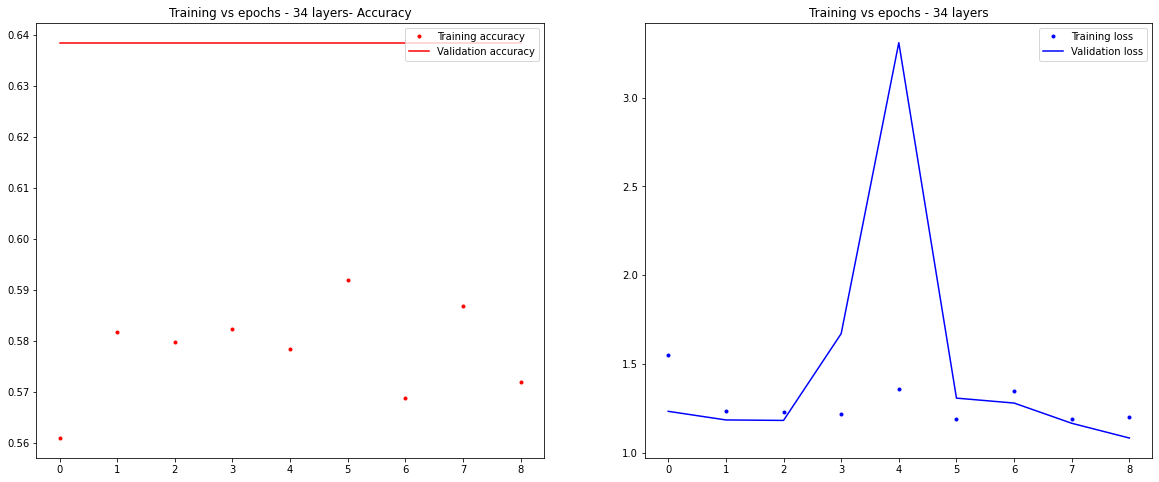

In [ ]:
plot_training(history, 'Training vs epochs - 34 layers')

In [ ]:
# salvo il modello creato
MC_CHECKPOINT = 'multiclass_resnet_34_3d_trained_regfactor003'
model_file = os.path.join(DB_MODELS, MC_CHECKPOINT) + '.h5'
model.save(model_file)
#model = tf.keras.models.load_model(model_file)

In [ ]:
ciclo = n_val_samples
images, labels = get_data_for_predict(validation_tfrec, ciclo,_decode, preprocessing_fn=whitening_fn)

In [ ]:
classification_report(model, images, labels, LABELS, 'classification_report - 34 layers')

9/9 [==============================] - 4s 439ms/step
{
    "CN": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 67
    },
    "MCI": {
        "precision": 0.6384615384615384,
        "recall": 1.0,
        "f1-score": 0.7793427230046948,
        "support": 166
    },
    "AD": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 27
    },
    "accuracy": 0.6384615384615384,
    "macro avg": {
        "precision": 0.2128205128205128,
        "recall": 0.3333333333333333,
        "f1-score": 0.2597809076682316,
        "support": 260
    },
    "weighted avg": {
        "precision": 0.40763313609467455,
        "recall": 0.6384615384615384,
        "f1-score": 0.497580353918382,
        "support": 260
    }
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 4s 443ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


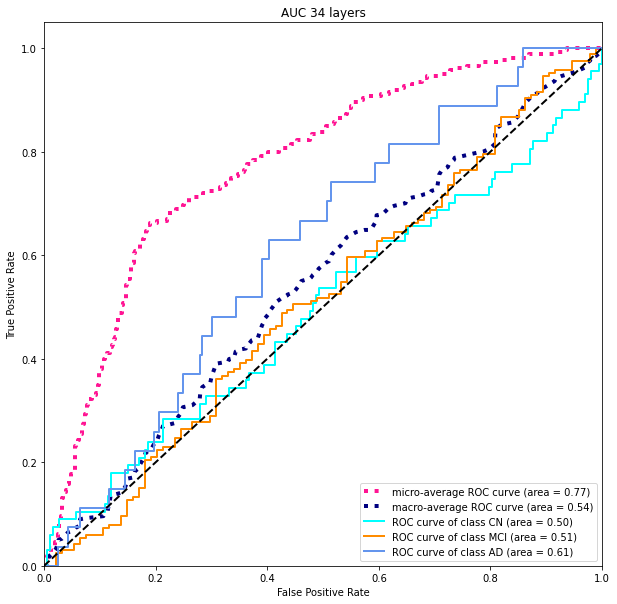

In [ ]:
compute_auc(model, images, labels, ['CN', 'MCI', 'AD'], title='AUC 34 layers')

Nel grafico appena riportato abbiamo la verifica del ROC (Falsi positivi e negativi).

## Creazione modello con architettura VGG-16

Definizione del modello VGG con 16 layer

In [ ]:
def vgg(input_shape, n_classes):
  #numero di parametri:
  input = Input(input_shape)
  # 64 indica il numero di filtri di output della convoluzione
  #3 profondità, l'altezza e la larghezza
  x = Conv3D(64, 3, padding='same', activation='relu',data_format="channels_last")(input)
  x = Conv3D(64, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2) , padding='same')(x)
  
  x = Conv3D(128, 3, padding='same', activation='relu')(x)
  x = Conv3D(128, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
  
  x = Conv3D(256, 3, padding='same', activation='relu')(x)
  x = Conv3D(256, 3, padding='same', activation='relu')(x)
  x = Conv3D(256, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2,2, 2), padding='same')(x)
  
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
  
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

Riporto alcuni aspetti chiave per l'addestramento del modello:

1. **Conv3D**: Strato di convoluzione 3D/2D (ad es. convoluzione spaziale su volumi).Questo livello crea un kernel di convoluzione che viene convogliato con l'input del livello per produrre un tensore di output.

2. **MaxPool3D**:Max operazione di pooling per dati spaziali 2D.Esegue il downsampling dell'input lungo le sue dimensioni spaziali (altezza e larghezza) prendendo il valore massimo su una finestra di input (di dimensioni definite da pool_size) per ciascun canale dell'input. La finestra viene spostata strideslungo ogni dimensione.

3. **Flatten**:Appiattisce l'input. Non influisce sulla dimensione del lotto.

4. **Dense**: Normale livello di rete neurale profondamento connesso. Questo rappresenta il livello più comune e utilizzato di frequente. Nel layer dense ogni neurone riceve input da tutti i neuroni dallo stato precedente. Il layer Dense è utilizzato per la classificazione di immagini in base all'output dei livelli convoluzionali.

5. **Dropout**: E' una tecnica di regolarizzazione. Prevede l'omissione dei neuroni che agiscono come rilevatori di caratteristiche della rete neurale durante ogni fase di addestramento. L'esclusione è determinata causalmente. L'obiettivo del dropout è anche quello di ridurre a minimo l'effetto dell'overfitting.

In [ ]:
Model_vgg_3D=vgg(IMG_SHAPE,n_classes=3)

In [ ]:
Model_vgg_3D.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

In [ ]:
Model_vgg_3D.summary()

Prima di addestrare il modello impostiamo i seguenti metodi:

1. **loss**: Lo scopo delle funzioni di perdita è calcolare la quantità che un modello dovrebbe cercare di ridurre al minimo durante l'addestramento. Impostiamo binary_crossentropy in quanto abbiamo solo due categorie (cane e gatto)

2. **optimizer RMSprop**: Ottimizzatore che implementa l'algoritmo RMSprop. L'essenza di RMSprop è:

  * Mantenere una media mobile (scontata) del quadrato dei gradienti
  * Dividi il gradiente per la radice di questa media Questa implementazione di RMSprop utilizza lo slancio semplice, non lo slancio Nesterov.La versione centrata mantiene inoltre una media mobile dei gradienti e utilizza tale media per stimare la varianza.

In [ ]:
#
train_model_VGG3D = Model_vgg_3D.fit(x=image_tensor, y=label_tensor, 
                    epochs=5, steps_per_epoch=STEPS_PER_EPOCH+1000, 
                    validation_data=val_tensor, 
                    validation_steps=VALIDATION_STEPS,
                    verbose=1)

Epoch 1/5
1091/1091 [==============================] - 1075s 975ms/step - loss: 1.1949 - acc: 0.5820 - val_loss: 0.9203 - val_acc: 0.6385
Epoch 2/5
1091/1091 [==============================] - 1036s 949ms/step - loss: 0.9657 - acc: 0.5834 - val_loss: 0.8751 - val_acc: 0.6385
Epoch 3/5
1091/1091 [==============================] - 1034s 948ms/step - loss: 0.9564 - acc: 0.5852 - val_loss: 0.8761 - val_acc: 0.6385
Epoch 4/5
 417/1091 [==========>...................] - ETA: 10:21 - loss: 0.9937 - acc: 0.5815

1091/1091 [==============================] - 417s 382ms/step - loss: 0.9937 - acc: 0.5815 - val_loss: 0.8776 - val_acc: 0.6385


In [ ]:
# salvo il modello creato
MC_CHECKPOINT = 'multiclass_vgg_16_trained_regfactor003'
model_file = os.path.join(DB_MODELS, MC_CHECKPOINT) + '.h5'
Model_vgg_3D.save(model_file)
#model = tf.keras.models.load_model(model_file)

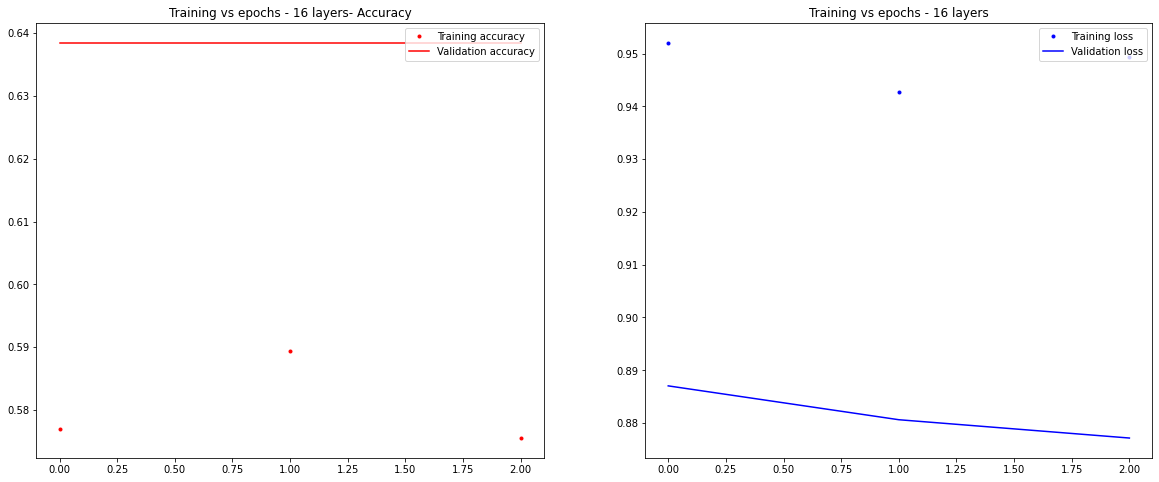

In [ ]:
plot_training(train_model_VGG3D, 'Training vs epochs - 16 layers')

## Confronto ResNet3D e VGG-16

Prima di mostrare i risultati ottenuti confrontando le due reti neurali costruite **"ResNet3D"** e **VGG-16** riassumiamo, in breve, cosa è stato fatto in questo notebook:



*   **Dataset**: Abbiamo lavorato su un set di **2042 immagini** di tipo **MRI** con estensione .nii cosi ditribuite:

    1.   **MCI** (mild cognitive impairment): 1206 immagini;
    2.   **AD** (Alzheimer's disease): 269 immagini;
    3.   **CN** (cognitively normal): 567 immagini;

    Le immagini sono state scaricate dal sito **ADNI** (Alzheimer's Disease Neuroimaging initiative)

*   **Fase di preprocessing** : In questa fase abbiamo processato e registrato le immagini.

  Gli aspetti tratti sono stati i seguenti:

    1.   Normalizzazione delle immagini;
    2.   Ricampionamento delle immagini;
    3.   Registrazione in base ad un'atlas di riferimento;
    4.   Rimozione della parte relativa al craino (cosi da consentire all'addestramento dell'algoritmo di lavorare con maggiore precisione);

*   Creazione del database **TFRecord**:
 
    Per migliorare le prestazioni nella fase di addestramento del modello abbiamo costruito un database di tipo TF. L'utilizzo del TFRecord ci permette di memorizzare una sequenza di record binari. E' progettato per l'uso con tensorflow e viene utilizzato in tutte le API di livello superiore come TFX.
    
*   Costruzione del modello di apprendimento, basato sulle reti neurali **ResNet3D** e **VGG-16**.

Mostriamo i risultati ottenuti dalle due fasi di addestramento:

***ResNet3D***:

*91/91 - 68s - loss: 1.2455 - acc: 0.5756 - val_loss: 1.2243 - val_acc: 0.6385*

***VGG-16***:

*1091/1091 loss: 0.9937 - acc: 0.5815 - val_loss: 0.8776 - val_acc: 0.6385*

Come si può notare il val_acc (valore accuratezza) di entrambe le reti si attesta su **0.6385**.
Per gli altri parametri, anche se la differenza risulta essere minima, la VGG sembra lavorare meglio.

Da questo studio però si è evidenziato molto il limite computazionale quando si lavora con il deepLearning.
Infatti, anche se è stato previsto l'abbonamento a **colab pro**, che ci consente di ottenere RAM/GPU maggiore, abbiamo avuto non pochi problemi a consentire l'addestramento delle reti.
In particolare, la VGG ha tempi di addestramento sicuramente maggiori e più volte ci siamo trovati a gestire valore di  out of memory.
Per ovviare a questi problemi, oltre ad aumentare le risorse per l'addestramento, abbiamo regolato ad-hoc i parametri di epochs e steps_per_epoch.

Altro limite molto importante è anche dovuta alla quantità di immagini necessarie per addestrare il modello.
Per questo lavoro abbiamo lavorato su 2042 immagini che occupano uno spazio di circa 40 Giga.
Per questo studio tale quantità può anche bastare, ma è ovvio che nel caso in cui volessimo realizzare un modello più preciso è necessario estrarre un numero maggiore di immagini che richiederebbero sicuramente uno spazio Disco e Ram maggiore (attualmente non disponibile con colab pro).

Quindi, in conclusione, la rete neurale VGG-16 sembra ottenere prestazioni maggiori, ma è sicuramente necessario e prioritario superare i problemi infrastrutturali.